# Binary Classification with Logistic Regression

In this notebook, we'll build a binary classifier using logistic regression to distinguish between images of cats and non-cats. 
Binary classification is a fundamental task in machine learning where the goal is to categorize an input into one of two possible classes. In our case, the two classes are 'cat' and 'non-cat'.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

## Load Dataset

The dataset consists of labeled images, with each label indicating whether the image is a cat or not. 
We'll start by loading this dataset and exploring its structure. This will give us an idea about the number of samples, the dimensions of each image, and the distribution of the classes.    

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


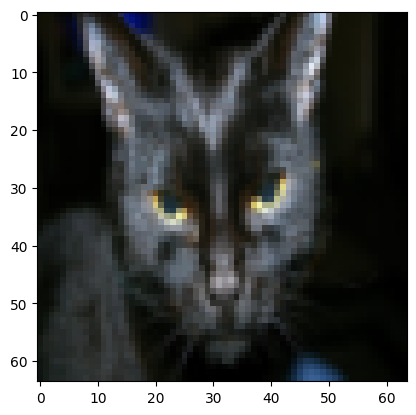

In [12]:
# Example of a picture
index = 25
plt.imshow(train_set_x_orig[index])

decoded_class = classes[np.squeeze(train_set_y[:, index])].decode("utf-8")
print(f"y = {train_set_y[:, index]}, it's a '{decoded_class}' picture.")

## Preprocessing

Before feeding the images into our algorithm, they need to be preprocessed. Typically, this involves several steps:
- Reshaping the images to ensure they all have the same dimensions.
- Normalizing the pixel values to be between 0 and 1.
- Splitting the dataset into training and testing sets to evaluate the model's performance later on.    

In [13]:
# Number of train/test examples
m_train, m_test = train_set_x_orig.shape[0], test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

In [14]:
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [15]:
train_set_x_flatten = train_set_x_orig.reshape(m_train, -1).T
test_set_x_flatten = test_set_x_orig.reshape(m_test, -1).T

In [16]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [17]:
# Standardize the dataset
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

## Building the Algorithm

In this section, we'll detail the logistic regression algorithm's components, including:
- The initialization of parameters.
- The forward and backward propagation steps for learning the parameters.
- The optimization algorithm (e.g., gradient descent) to minimize the cost function.    

In [18]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [19]:
def initialize_with_zeros(dim):
    w = np.zeros((dim, 1))
    b = 0.
    return w, b

In [20]:
def propagate(w, b, X, Y):
    """
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    grads -- dictionary containing the gradients of the weights and bias
            (dw -- gradient of the loss with respect to w, thus same shape as w)
            (db -- gradient of the loss with respect to b, thus same shape as b)
    cost -- negative log-likelihood cost for logistic regression    
    """
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = -1/m * np.sum(Y*np.log(A) + (1-Y)*np.log(1-A))

    dw = 1/m * np.dot(X, (A - Y).T)
    db = 1/m * np.sum(A - Y)
    
    cost = np.squeeze(np.array(cost))
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [21]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]

        w = w - learning_rate*dw
        b = b - learning_rate*db

        if i % 100 == 0:
            costs.append(cost)
        
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [22]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] >= 0.5 else 0
    
    return Y_prediction

## Model Training and Evaluation

Once the algorithm is set up, the next step is to train the model using the training dataset. 
By iteratively updating the model's parameters, we aim to minimize the difference between the predicted and actual labels. 
After training, the model is then evaluated on the test set to determine its accuracy and effectiveness in classifying unseen data.    

In [26]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.005, print_cost=False):
    """
    Builds the logistic regression model.
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """

    w, b = initialize_with_zeros(X_train.shape[0])
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate)
    w, b = params['w'], params['b']
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [27]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y)

y = 1, you predicted that it is a cat picture.


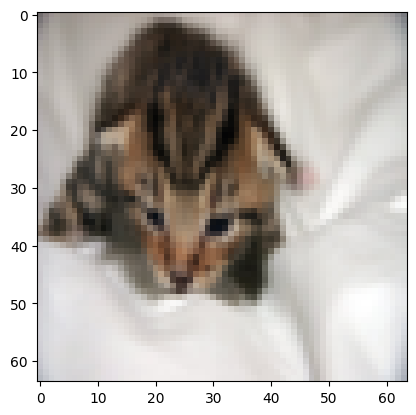

In [28]:
# Example of a picture that was wrongly classified.
index = 1
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))

decoded_class_test = classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8")
print(f"y = {test_set_y[0,index]}, you predicted that it is a {decoded_class_test} picture.")

## History: Cost function and the gradients

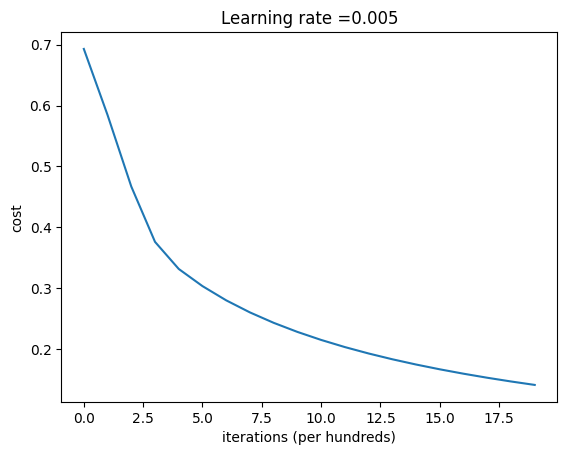

In [29]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

**Interpretation**:
We can see the cost decreasing. It shows that the parameters are being learned. However, we see that we could train the model even more on the training set.